# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/AnimalDataset.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image #image loading
import torch #to bring the pretrained models
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

In [ ]:
#Resize the image to 224x224 px
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def extract_feature_vector(img,modelType):

    if modelType == "resnet101":
      model = models.resnet101(weights='ResNet101_Weights.DEFAULT')
      model.eval()
      layer = model._modules.get('avgpool')
      my_embedding = torch.zeros(1,2048, 1, 1)

    elif modelType == "alexnet":
      model = models.alexnet(weights='AlexNet_Weights.DEFAULT')
      model.eval()
      layer = model._modules.get('avgpool')
      my_embedding = torch.zeros(1,256, 6, 6)

    elif modelType == "vgg16":
      model = models.vgg16(weights='VGG16_Weights.DEFAULT')
      model.eval()
      layer = model._modules.get('avgpool')
      my_embedding = torch.zeros(1,512, 7, 7)
      
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))

    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)

    # 6. Run the model on our transformed image
    model(t_img)

    # 7. Detach our copy function from the layer
    h.remove()

    # 8. Return the feature vector
    return my_embedding.squeeze().numpy()

In [ ]:
from PIL import Image
#Download the image into memory given the URL.
def get_image_from_url(url):
    return Image.open(url)


In [ ]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from matplotlib import pyplot as plt 

def get_cosine_distance(im_url1, im_url2,modelType1,modelType2):
    im1, im2 = get_image_from_url(im_url1), get_image_from_url(im_url2)
    image1 = extract_feature_vector(im1,modelType1).reshape(1, -1)
    image2 = extract_feature_vector(im2,modelType2).reshape(1, -1)

    if(modelType1=="alexnet" and modelType2=="vgg16"):
      image1 = image1[0][:9216].reshape(1, -1)
      image2 = image2[0][:9216].reshape(1, -1)
    elif(modelType1=="alexnet" and modelType2=="resnet101"):
      image1 = image1[0][:2048].reshape(1, -1)
      image2 = image2[0][:2048].reshape(1, -1)
    elif(modelType1=="vgg16" and modelType2=="resnet101"):
      image1 = image1[0][:2048].reshape(1, -1)
      image2 = image2[0][:2048].reshape(1, -1)

    return cosine_distances(image1, image2)

In [ ]:
from PIL import Image
import glob
distance_list = []
filename = "/content/AnimalDataset/chicken/OIP---QC8fffuti7aIXLcrIhggHaFK.jpeg"

print('Distance between alexnet and vgg16 images :', get_cosine_distance(filename,filename,"alexnet","vgg16")[0][0])
distance_list.append(get_cosine_distance(filename,filename,"alexnet","vgg16")[0][0])

print('Distance between alexnet and resnet101 images :', get_cosine_distance(filename,filename,"alexnet","resnet101")[0][0])
distance_list.append(get_cosine_distance(filename,filename,"alexnet","resnet101")[0][0])

print('Distance between vgg16 and resnet101 images :', get_cosine_distance(filename,filename,"vgg16","resnet101")[0][0])
distance_list.append(get_cosine_distance(filename,filename,"vgg16","resnet101")[0][0])

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Distance between alexnet and vgg16 images : 0.8662306


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Distance between alexnet and resnet101 images : 0.91781765
Distance between vgg16 and resnet101 images : 0.9750769


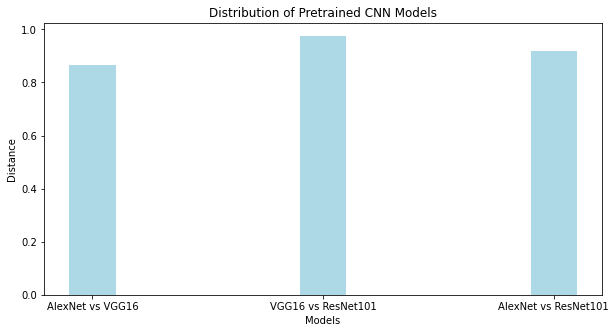

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
 
# creating the dataset
data = {'AlexNet vs VGG16':distance_list[0],'VGG16 vs ResNet101':distance_list[2], 'AlexNet vs ResNet101':distance_list[1]}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='lightblue',
        width = 0.2)
 
plt.xlabel("Models")
plt.ylabel("Distance")
plt.title("Distribution of Pretrained CNN Models")
plt.show()
